# 0. Importar librerías, definir variables globales y funciones

## 0.1 Librerías

In [1]:
from scipy import spatial
import numpy as np
import math
from itertools import islice
import matplotlib.pyplot as plt

## 0.2 Variables globales

In [2]:
# Nombre de la base de datos del proyecto final
BD = "proyecto_final"

# La proyección del usuario en el espacio vectorial para realizar la recomendación
PROJ_USER = [10, 5, 2, 1, 1, 1]

# Diccionarios para hacer la visualizacion de datos y cambiar de id a nombre legible
DIC_CAMPOS_BD = {
     1: "arte_diseno_arquitectura",
     2: "agricultura_forestal",
     3: "empresariales_administracion",
     4: "economicas",
     5: "educacion",
     6: "ingenieria_tecnologia",
     7: "historia_filosofia_teologia",
     8: "leyes_abogacia",
     9: "ciencias_salud",
    10: "ciencias_naturales",
    11: "ciencias_sociales",
    12: "otros",
}

DIC_CAMPOS_USUARIO = {
    "arte_diseno_arquitectura": "Arte, diseño y arquitectura",
    "agricultura_forestal": "Agricultura y forestal",
    "empresariales_administracion": "Empresariales y administración",
    "economicas": "Economía",
    "educacion": "Educación",
    "ingenieria_tecnologia": "Ingeniería y tecnología",
    "historia_filosofia_teologia": "Historia, filosofía y teología",
    "leyes_abogacia": "Leyes y abogacía",
    "ciencias_salud": "Ciencias de la salud",
    "ciencias_naturales": "Ciencias naturales",
    "ciencias_sociales": "Ciencias sociales",
    "otros": "Otros",
}



## 0.3 Funciones

In [83]:
def take(n, iterable):
    """
    Return the first n items of the iterable as a list.
    
    Input:
        n (int): The size of each slice
        iterable: The iterable item to slice
        
    Returns:
        sliced_iterable (list): A list with the sliced iterable
    """
    sliced_iterable = list(islice(iterable, n))
    return sliced_iterable

                           
def get_investigators_per_field(fields_id):
    """
    Reads from hive a view where each row contains the university info, a field and the investigators in that field
    
    Input:
        fields_id(list): A string list containing the id of the user's interest fields
    
    Returns:
        rankings_df(DataFrame): A dataframe with the resulting query (columns: nombre_univ, nombre_campo, id_univ, id_campo, puntuacion)
    """
                           
    # Select sentence to get the desired columns
    sentencia_select = f"""
                        SELECT 
                        {BD}.universidades.nombre AS nombre_univ, 
                        {BD}.campos.nombre AS nombre_campo, 
                        {BD}.rankings.id_univ, 
                        {BD}.rankings.id_campo, 
                        {BD}.rankings.puntuacion 
                        FROM {BD}.campos
                        """
    # The join sentence to combine tables
    sentencia_join = f"""
                      INNER JOIN {BD}.rankings ON {BD}.campos.id = {BD}.rankings.id_campo
                      INNER JOIN {BD}.universidades ON {BD}.universidades.id = {BD}.rankings.id_univ
                      """
                           
    # The where sentence to only get rows related to the user selected fields
    ids_str = ','.join(fields_id)
    sentencia_where = f"WHERE {BD}.campos.id IN ({ids_str})"
    
    # The complete sql sentence
    sentencia_sql = f"""
                    {sentencia_select}
                    {sentencia_join}
                    {sentencia_where}
                    """

    
    # Execute the sentence to read from hive
    rankings_df = spark.sql(sentencia_sql).fillna(0)
    return rankings_df
                           

def calcular_especialidad(unis_dict, id_especialidad, especialidad_key):
    """
    Updates the universities dictionary to add information about the specialization of a university in a field
    based on the number of degrees in that field
    
    Input:
        unis_dict (dictionary): A dictionary containing a subdictionary by university key, subdictionary contains
                                the information for the projection that will be used
        id_especialidad (string): The string representing the field id in the database
        especialidad_key(string): The speciality or field key in the uni dictionary
    
    Returns:
        None
                                
    """
    # Select sentence to get the desired columns
    sentencia_select = f"""
                        SELECT 
                        {BD}.universidades.id AS id_univ, 
                        {BD}.universidades.nombre AS nombre_univ, 
                        {BD}.campos.nombre AS nombre_campo, 
                        COUNT(*) AS carreras 
                        FROM {BD}.campos
                        """
    
    # Join sentece to merge desired tables
    sentencia_join = f"""
                      INNER JOIN {BD}.facultades ON {BD}.campos.id = {BD}.facultades.id_campo 
                      INNER JOIN {BD}.grados ON {BD}.grados.id_fac = {BD}.facultades.id 
                      INNER JOIN {BD}.universidades ON {BD}.universidades.id = {BD}.facultades.id_univ
                      """

    
    # Where sentence to query only for the desired speciality or field
    sentencia_where = f"WHERE {BD}.campos.id IN ({id_especialidad})"
    
    # Group by sentence to count degrees by field
    sentencia_group_by = f"GROUP BY {BD}.campos.nombre, {BD}.universidades.nombre, {BD}.universidades.id"
    
    # Order by sentence to order in descending order by the number of degrees in a field
    sentencia_order_by = 'ORDER BY COUNT(*) DESC'
    sentencia_sql = f"""
                     {sentencia_select} 
                     {sentencia_join}
                     {sentencia_where}
                     {sentencia_group_by}
                     {sentencia_order_by}
                     """
    
    # Execute the sentence to read from hive
    carreras_total_df = spark.sql(sentencia_sql).collect()
    
    # Calculate the maximum number of degrees of a field in a university
    max_especialidad = carreras_total_df[0]['carreras']
    
    # Update the unis_dict
    for row in carreras_total_df:
        id_univ = row['id_univ']
        num_carreras = row['carreras']
        # We set the speciality as the logarithm of the number of degrees with base equal to the max number of degrees
        unis_dict[id_univ][especialidad_key] = math.log(num_carreras, max_especialidad)

        
def calculate_uni_projection(uni_dict, selected_ids):
    """
    Computes the projection of the universities and stores it in a list
    
    Input:
        uni_dict (dictionary): The dictionary containing the info of the university
        selected_ids (string): A string list containing the selected fields by the user
        
    Returns:
        proj (list): An int list containing the computed projection of the university
    """
    
    # Check that the university has at least one investigator in the selected fields
    total_investigators = 0
    for investigators in uni_dict.values():
        total_investigators += investigators
    
    # If it has no investigators in the fields, then return a projection far away from the user projection
    if total_investigators == 0:
        return [-100, -100, -100, -1, -1, -1]
    
    # Get the three first keys and values of the uni dictionary to compute the speciality or field with more investigators
    kv_pairs = take(3, uni_dict.items())
    sub_dict = {}
    for k, v in kv_pairs:
        sub_dict[k] = v
    ordered_dict = sorted(sub_dict.items(), key=lambda x:x[1], reverse=True)
    punctuations_dict = {}
    
    # Assign to each field the values 10, 5, and 2 to the fields ordered descending by the number of investigators in 
    # each field, if any field has no investigators then assign -100 to that coordinate in the projection
    if ordered_dict[0][1] == 0:
        punctuations_dict[ordered_dict[0][0]] = -100
    else:
        punctuations_dict[ordered_dict[0][0]] = 10
    
    if ordered_dict[1][1] == 0:
        punctuations_dict[ordered_dict[1][0]] = -100
    else:
        punctuations_dict[ordered_dict[1][0]] = 5
    
    if ordered_dict[2][1] == 0:
        punctuations_dict[ordered_dict[2][0]] = -100
    else:
        punctuations_dict[ordered_dict[2][0]] = 2
    
    uni_proj = []
    for campo in selected_ids:
        percentage = uni_dict[int(campo)]
        uni_proj.append(punctuations_dict[int(campo)])
        
    # Finally add how specialized is a university in a field based on the number of degrees in the field (previously computed)
    uni_proj.append(uni_dict['especialidad1'])
    uni_proj.append(uni_dict['especialidad2'])
    uni_proj.append(uni_dict['especialidad3']) 
    
    # Return the computed projection
    return uni_proj


def get_three_most_similar_unis(projs_dict, proj_user):
    """
    Searches for the three most similar unis to the user preferences based on the distance of the projections
    
    Input:
        projc_dict (dictionary): A dictionary with the projections of the universities with the university id as key
        proj_user (list): An int list with the projection of the user preferences
        
    Returns:
        best_three_ids (list): An int list with the three best universities ids
    """
    
    # Converto to numpy array the user projection
    np_user_proj = np.array(proj_user)
    
    # Create a similarities dictionary to order later
    similarities_dict = {}
    
    # Iterate through the projections computing euclidean distance
    for uni_key, proj in projs_dict.items():
        np_uni_proj = np.array(proj)
        similarities_dict[uni_key] = np.linalg.norm(np_user_proj-np_uni_proj)
    
    # Order the similarities
    similarities_ordered = sorted(similarities_dict.items(), key=lambda x:x[1])
    
    # Return the first three universities
    best_three = similarities_ordered[:3]
    best_three_ids = []
    for u in best_three:
        best_three_ids.append(u[0])
    return best_three_ids


def get_universities_by_id(unis_ids):
    """
    Gets the initials and h_indexes of the universities
    """
    unis_id_str = [str(uid) for uid in unis_ids]
    unis_str = ','.join(unis_id_str)
    sentencia_select = f"SELECT {BD}.universidades.siglas, {BD}.universidades.posicion_hindex FROM {BD}.universidades"
    sentencia_where = f"WHERE {BD}.universidades.id IN ({unis_str})"
    sentencia_sql = f"""
                     {sentencia_select}
                     {sentencia_where}
                     """
    recommended_unis_df = spark.sql(sentencia_sql)
    return recommended_unis_df


def visualizar_posiciones_hindex(recomendaciones):
    
    datos_ranking_hindex = get_universities_by_id(recomendations)
    datos_hindex_rows = datos_ranking_hindex.fillna(0).orderBy(datos_ranking_hindex.posicion_hindex).collect()
    
    inverse_hindexes= [130-datos_hindex_rows[1]['posicion_hindex'], 
                       130-datos_hindex_rows[0]['posicion_hindex'],
                       130-datos_hindex_rows[2]['posicion_hindex']]
    
    hindexes= [datos_hindex_rows[1]['posicion_hindex'], 
               datos_hindex_rows[0]['posicion_hindex'],
               datos_hindex_rows[2]['posicion_hindex']]
    
    siglas =[datos_hindex_rows[1]['siglas'], 
             datos_hindex_rows[0]['siglas'],
             datos_hindex_rows[2]['siglas']]
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.set_ylim(0, 150-datos_hindex_rows[0]['posicion_hindex'])
    ax.yaxis.set_tick_params(labelleft=False)
    
    
    
    for i in range(len(hindexes)):
        plt.text(i, inverse_hindexes[i]+5, f"{hindexes[i]}º", ha = 'center', fontdict={'fontsize':14})
    
    paleta=['#814DFF', '#FF83B6', '#FF9022']
    ax.bar(siglas, inverse_hindexes, width=0.8,color=paleta)
    ax.tick_params(left=False)
    plt.xticks(fontsize=16)
    ax.set_title('Posiciones H-index de las universidades', loc = 'left', fontdict={'fontsize':18, 'fontweight':'bold', 'color':'gray'})
    ax.grid(axis ='y', color = 'gray', linestyle = 'dashed')

# 1. Cuestionario del alumno

In [4]:
print("Introduce el identificador de 3 campos de tu interés de mayor a menor preferencia:")
for key, value in DIC_CAMPOS_BD.items():
    print(f"{'{:3d}'.format(key)}. {DIC_CAMPOS_USUARIO[value]}")
print()

completed = False
selected_ids = []
max_length = 3
while not completed:
    selection = input(f"Introduce el identificador de tu elección ({len(selected_ids)}/{max_length}): ")
    if selection not in selected_ids:
        print(f"    Has elegido {DIC_CAMPOS_USUARIO[DIC_CAMPOS_BD[int(selection)]]}")
        selected_ids.append(selection)
        if len(selected_ids) == max_length:
            completed = True
    else:
        print("    Error: Ya has escogido ese campo")

Introduce el identificador de 3 campos de tu interés de mayor a menor preferencia:
  1. Arte, diseño y arquitectura
  2. Agricultura y forestal
  3. Empresariales y administración
  4. Economía
  5. Educación
  6. Ingeniería y tecnología
  7. Historia, filosofía y teología
  8. Leyes y abogacía
  9. Ciencias de la salud
 10. Ciencias naturales
 11. Ciencias sociales
 12. Otros

Introduce el identificador de tu elección (0/3): 4
    Has elegido Economía
Introduce el identificador de tu elección (1/3): 5
    Has elegido Educación
Introduce el identificador de tu elección (2/3): 11
    Has elegido Ciencias sociales


Hacemos query para obtener información de las universidades y campos

In [5]:
rankings_df = get_investigators_per_field(selected_ids)
rankings_df.show()

2023-07-27 14:51:14,882 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-07-27 14:51:14,882 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-07-27 14:51:16,502 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


+--------------------+-----------------+-------+--------+----------+
|         nombre_univ|     nombre_campo|id_univ|id_campo|puntuacion|
+--------------------+-----------------+-------+--------+----------+
|Universidad Nacio...|       economicas|     36|       4|         5|
|Universidad Nacio...|        educacion|     36|       5|         4|
|Universidad Nacio...|ciencias_sociales|     36|      11|        13|
|Universidad Obert...|       economicas|     37|       4|         4|
|Universidad Obert...|        educacion|     37|       5|         9|
|Universidad Obert...|ciencias_sociales|     37|      11|        39|
|Universidad Polit...|       economicas|     41|       4|         1|
|Universidad Polit...|        educacion|     41|       5|         3|
|Universidad Polit...|ciencias_sociales|     41|      11|         6|
|Universidad de Ba...|       economicas|     57|       4|        23|
|Universidad de Ba...|        educacion|     57|       5|        21|
|Universidad de Ba...|ciencias_soc

# 2. Procesamiento de datos

Creamos un iterable del resultado de la query

In [6]:
list_of_unis = zip(*(iter(rankings_df.collect()),) * 3)

Creamos un diccionario de universidades para procesar la información que usaremos para calcular la proyección de la universidad

In [7]:
unis_dict = {}
for campo_1, campo_2, campo_3 in list_of_unis:
    uni_dict = {campo_1['id_campo']: campo_1['puntuacion'],
                campo_2['id_campo']: campo_2['puntuacion'],
                campo_3['id_campo']: campo_3['puntuacion'],
                'especialidad1': -1,
                'especialidad2': -1,
                'especialidad3': -1
                }
    unis_dict[campo_1['id_univ']] = uni_dict

Añadimos al diccionario el nivel de especialización por campo

In [8]:
calcular_especialidad(unis_dict, selected_ids[0], 'especialidad1')
calcular_especialidad(unis_dict, selected_ids[1], 'especialidad2')
calcular_especialidad(unis_dict, selected_ids[2], 'especialidad3')

Calculamos las proyecciones de las universidades

In [9]:
projs_dict = {}
for key, value in unis_dict.items():
    projs_dict[key] = calculate_uni_projection(value, selected_ids)

# 3. Búsqueda de universidades

Calcular las tres universidades más cercanas a las preferencias de usuario en base a sus proyecciones

In [11]:
recomendations = get_three_most_similar_unis(projs_dict, PROJ_USER)

# 4. Visualización

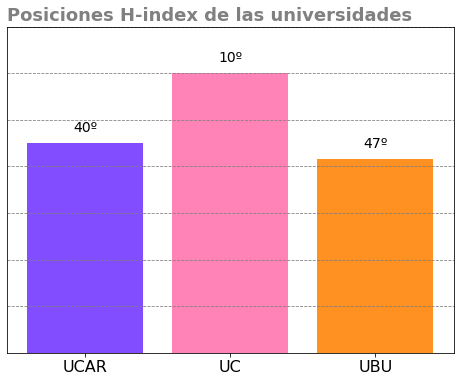

In [85]:
visualizar_posiciones_hindex(recomendations)